# CRISP-DM Analysis for Business Problem: Innactivity prediction with transactional data

This notebook is a companion to the Medium article (link bellow) the underlies the application with CRISP-DM methodology to understand, analyze and communicate a business problem through a proven and tested Data Science methodology.

CRISP-DM comprises of 6 steps:

Section 1: Business Understanding

Section 2: Data Understanding

Section 3: Data Preparation

Section 4: Data Modeling

Section 5: Evaluate the Results

Section 6: Deployment

Medium Article:
https://medium.com/@fernandocarliniguimaraes/innactivity-prediction-using-machine-learning-on-transacional-data-642ef7c84674

# Section 1: Business Understanding

The broader business contextualization is laid in the companion Medium Article.
A brief summary of the business undersating is laid out bellow:
A Brazilian Credit Union wishes to preempively predict Mobile phone app innactivity in a six month window. 

The business value of such endeavor lies on: 
- (1) expanding use cases of a dataset (data enrichment may lead to revenue growth); 
- (2) deterring potential customer churn (avoid revenue lost);
- (3) early detection of customer friction (garantee user satisfaction).

The business questions that arise pertaing such objective are:

### Question 1: What are aspects of a transactional dataset that can be used for understanding channel innactivity in a six month window?

### Question 2: Are mono-product-family users more likely to have channel innactivity in a six month window?

### Question 3: Can transactional data alone safely predict channel innactivity in a six month window?
    


# Section 2: Data Understanding

### Credit Union's Transaction Dataset overview

Since this project deals with classified company owned information, we won't be able to show a complete exploratory analysis.

So here is a small low level description:

The Credit Union has several client channels. For this project we are looking at only one of them: the mobile phone app. It has roughlly 4 million users, with an average of 40–45 Million transactions per month, about 40% of these are financial transacions (like paying a bill) and 60% non-financial (like looking up a bill receipt). Our main goal for the project is avoidind financial transaction innactivity, so we focused onlty on those.

All of these transactions are stored in a main database that is daily ingested in AWS Data Lake. That was the interface I used to query the data and extract it for the project.

The transacional database holds A LOT of information. But, for this project the most vital informations used were:

- Time and date the transacion happend;
- The transaction code;
- The product family the transaction is part of (example: investment application and investment cashout are two different transactions of the same product family).¹
- The Credit Union Member who solicited the transaction;
- The Credit Union the Member is linked to;
- The status of the transacion. Did it complete? Or was it canceled?
- The channel through which the transaction was solicited;

¹ There are 8 main product familys: Channels (managing your self service channel), Checking account (wire transfers), Payments (Government Tribute or company Slips), Bills (Water, Phone, etc), Credit (Loans), Cards (Credit and debit) and PIX(Brazil’s own instant payment financial product), Investments (Long Term Deposits, Market Shares);

For this project I filtered the channel to be only the Mobile App. I also chose 5 medium sized Credit Unions from our system (we have over 140) so as to have a good amount of data, but not too much as to make the processing time too long. And also fixed a six month period to analyze data.

### IMPORTANT OBSERVATION: 
This dataset is quite clean because it’s a high management information system. When we use the filters described above, like the channel filter and completed status filter, we flush out basically anything that could get in our way. The heavier data wrangling necessary is grouping the transaction codes into product families and that is still quite easy to accomplish.

### Exploratory Analysis of the Transactional Database

I have written a second article piece that show cases the method I used for both the exploratory analysis and also the model selection and development. Please check it out the article, specially the <b>Data understanding — What data do we have / need? Is it clean?</b> section for further insight.

Link:
https://medium.com/@fernandocarliniguimaraes/innactivity-prediction-using-machine-learning-on-transacional-data-642ef7c84674

### Disclaimer about Compliance and Confidentiality

Due to company compliance I had to do all of the data wrangling and manipulation on our AWS Data Lake server using Redash running a AWS Athena and AthenaSQL engine. Data was only available for extraction after anonymization. I've included in the repository a SQL file with a pseudo algorhitm that masks the sensible information (like dataset names and columns) and shows how data manipulation was done.

GitHub Repo for this project: https://github.com/nandodsg/Innactivity-Prediction-with-Transactional-Data

##### Queries using during exploratory analysis:
1. pseudo query - exploratory analysis dataset (anonymous).sql :
https://github.com/nandodsg/Innactivity-Prediction-with-Transactional-Data/blob/main/pseudo%20query%20-%20exploratory%20analysis%20dataset%20(anonymous).sql
2. pseudo query - exporatory analysis - churn flags (anonymous).sql : 
https://github.com/nandodsg/Innactivity-Prediction-with-Transactional-Data/blob/main/pseudo%20query%20-%20exporatory%20analysis%20-%20churn%20flags%20(anonymous).sql

# Section 3: Data Preparation

### Classifier Models Data Set preparation

There can be many approches when it comes to modelling this specific business problem. One way to look at is to think of this sixth month innactivity as a kind of “churn” that we would want to predict based on a series of features (predictors). On this approch we could elect a Classifier Model for the problem.

On this solution framing we have to consider our dataset modeling base on individual and not on transactions (the would work for the Time Series model though).

We need one individual per row, with all the features laid out on separate columns. Based on the exploratory analysis I want to construct my dataframe with the following blocks:

- Account Number ID
- Credit Union Number ID
- Sixth Month Innactivity Flag (our future dependent variable)
- A depth counter (number of transacionts) by month and by product family
- An amplitude counter (number of diferente families used) by month
- Total depth counter by month
- Standard Deviation (by product family)
- 3 month window Moving Average (by product family)
- Absolute Moving Average variation (by product family)

The first 6 columns were prepare via SQL query. The last three items were calculated in a second notebook also found in this Repository called 'Data Wrangling for Innactivity Prediction'.

I extracted the data from the other 4 credit unions I had previously selected. This time bringing in every member who attendend one simple rule: they had to be active on the first by months of 2022. This extraction gave me a 91.848 long dataset, each row representing an unique individual.

### Disclaimer about Compliance and Confidentiality

Due to company compliance I had to do all of the data wrangling and manipulation on our AWS Data Lake server using Redash running a AWS Athena and AthenaSQL engine. Data was only available for extraction after anonymization. I've included in the repository a SQL file with a pseudo algorhitm that masks the sensible information (like dataset names and columns) and shows how data manipulation was done.

GitHub Repo for this project: https://github.com/nandodsg/Innactivity-Prediction-with-Transactional-Data

##### Query used to generate model dataset
1. pseudo query - model dataset.SQL : 
https://github.com/nandodsg/Innactivity-Prediction-with-Transactional-Data/blob/main/pseudo%20query%20-%20model%20dataset.SQL


# Section 4: Data Modeling

The following section details the development of 10 different Classifiers Models aimed at supporting the analyses of the three business questions.

I have written a second article piece that show cases the method I used for both the exploratory analysis and also the model selection and development. Please check it out the article, specially the <b>Modeling — What modeling techniques should we apply?</b> and the <b>Evaluation — Which model best meets the business objectives?</b> sections for further insight.

Link: https://medium.com/@fernandocarliniguimaraes/innactivity-prediction-using-machine-learning-on-transacional-data-642ef7c84674

In [1]:
# Utils class with functions for model development, testing and evaluation
import utils as u
%matplotlib inline

In [40]:
df_first_run = u.pd.read_csv('./Model Data Set STDEV MA (pseudo).csv',sep=',')
df_first_run.head()

,Unnamed: 0,CREDIT_UNION_ID,ACCOUNT_NUM,FLG_202201,FLG_202202,FLG_202203,FLG_202204,FLG_202205,FLG_202206,DEEP_CHANNELS_202201,...,PAYMENTS_MA_3,PAYMENTS_MA_VAR,AMP_MA_1,AMP_MA_2,AMP_MA_3,AMP_MA_VAR,NUM_TRANSACTIONS_MA_1,NUM_TRANSACTIONS_MA_2,NUM_TRANSACTIONS_MA_3,NUM_TRANSACTIONS_MA_VAR
0,0,A,ZWZZ!W,1,1,1,1,1,1,0,...,8.666667,2.666667,3.666667,3.333333,2.666667,-1.000000,94.666667,105.333333,99.333333,4.666667
1,1,A,&WXYY&,1,1,1,1,1,1,0,...,0.000000,-2.000000,2.000000,1.666667,1.666667,-0.333333,8.666667,12.000000,13.333333,4.666667
2,2,A,Y%@YZ&,1,1,1,1,1,1,0,...,0.000000,0.000000,2.000000,2.000000,1.666667,-0.333333,9.333333,9.333333,11.333333,2.000000
3,3,A,!W%&#!,1,1,1,1,1,1,0,...,1.333333,0.000000,2.666667,3.000000,2.666667,0.000000,32.666667,38.000000,54.000000,21.333333
4,4,A,%##AXY,1,1,1,1,1,1,0,...,2.666667,-0.666667,3.000000,2.666667,2.666667,-0.333333,16.000000,10.666667,8.666667,-7.333333


In [42]:
df_big_blind_test = u.pd.read_csv('./Big Blind Predict Test.csv',sep=',')
df_big_blind_test.head()

,Unnamed: 0,FLG_202201,FLG_202202,FLG_202203,FLG_202204,FLG_202205,FLG_202206,DEEP_CHANNELS_202201,DEEP_CHANNELS_202202,DEEP_CHANNELS_202203,...,PAYMENTS_MA_3,PAYMENTS_MA_VAR,AMP_MA_1,AMP_MA_2,AMP_MA_3,AMP_MA_VAR,NUM_TRANSACTIONS_MA_1,NUM_TRANSACTIONS_MA_2,NUM_TRANSACTIONS_MA_3,NUM_TRANSACTIONS_MA_VAR
0,0,1,1,1,1,1,1,0,0,0,...,10.666667,2.666667,2.333333,2.666667,3.000000,0.666667,26.666667,29.333333,32.000000,5.333333
1,1,1,1,1,1,1,1,0,0,0,...,3.333333,2.000000,2.000000,2.000000,2.000000,0.000000,18.000000,18.666667,19.333333,1.333333
2,2,1,1,1,1,1,1,0,0,0,...,15.333333,5.333333,2.333333,2.666667,2.666667,0.333333,53.333333,72.000000,79.333333,26.000000
3,3,1,1,1,1,1,1,0,0,0,...,1.333333,1.333333,2.000000,2.000000,1.666667,-0.333333,34.000000,20.666667,19.333333,-14.666667
4,4,1,1,1,1,1,1,0,0,0,...,4.000000,1.333333,3.000000,3.000000,3.333333,0.333333,25.333333,29.333333,38.666667,13.333333


In [43]:
# We make sure to create a copy of the data before we start altering it. Note that we don't change the original data we loaded.
data_first_run = df_first_run.copy(deep=False)
data_big_blind_test = df_big_blind_test.copy(deep=False)

# Handling class imbalance

We know from our exploratory analysis that this dataset will be havily imbalanced with churn on 6th month as the minority class (represented as inactivity on that month or FLG_202206 = 0). Check the histogram bellow for visual reference.

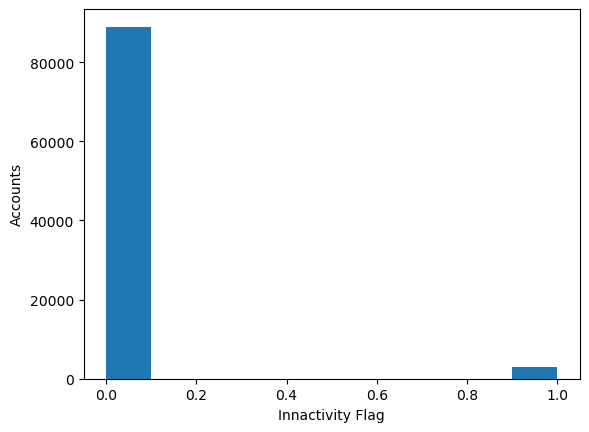

In [44]:
fig, axis = u.plt.subplots()
axis.hist(data_first_run['FLG_INNACTIVITY'])
u.plt.ylabel('Accounts')
u.plt.xlabel('Innactivity Flag')
u.plt.show()

The problem with classifiers and class imbalance is that the classifier will more easily classify the majority class, simply because most cases are of that class. For that reason model performance metrics have to be carefully selected. Precision, recall and F1 will be used as the main metrics for evaluating performance. In our specfic case we our most interested in those metrics regarding the prediction of the minority class (0 in our case).

So in this study we will contrast the use of two wildly used classification models: Logistic Regression and RandomTreeClassifier, both with SciKit Learn implementations. Tree Ensembles our suposabily better at handling inbalance. And a common technique for getting better results is using resampling techniques. For that we will contrast model metrics on baseline models with resampled models (RandomOverSampling, SMOTE and NearMisses)


Reference:

https://medium.com/grabngoinfo/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python-7304aedf9037

https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec

https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/

# Preparing Global Variables

In [51]:
#Declare independent variables (X) and dependent variable (y) for the Model Training and Setup dataset
X = data_first_run.loc[:,'DEEP_CHANNELS_202201':'NUM_TRANSACTIONS_MA_VAR'] # Drop Id columns
X = X.drop(columns=['FLG_INNACTIVITY']) # Drop prediction column
y = data_first_run['FLG_INNACTIVITY']

#Declare independent variables (X) and dependent variable (y) for the Big Blind Predict Test dataset
X_bbt = data_big_blind_test.loc[:,'DEEP_CHANNELS_202201':'NUM_TRANSACTIONS_MA_VAR'] # Drop Id columns
X_bbt = X_bbt.drop(columns=['FLG_INNACTIVITY']) # Drop prediction column
y_bbt = data_big_blind_test['FLG_INNACTIVITY']

#set shared model, scaler and splitter variables
random_state = 42
test_size = 0.30
verbose = 'off'
print_report = 'off'

#set model names
models = ['Random Forest',
          'Logistic Regression',
         ]

#set resampling method names
resamplers = [
              'Baseline',
              'Random Over Sampling',
              'SMOTE',
              'Near Miss KNN',
              'Random Under Sampling',
             ]

## Processing and evaluating models


Total processing time: --- 41.12545347213745 seconds ---


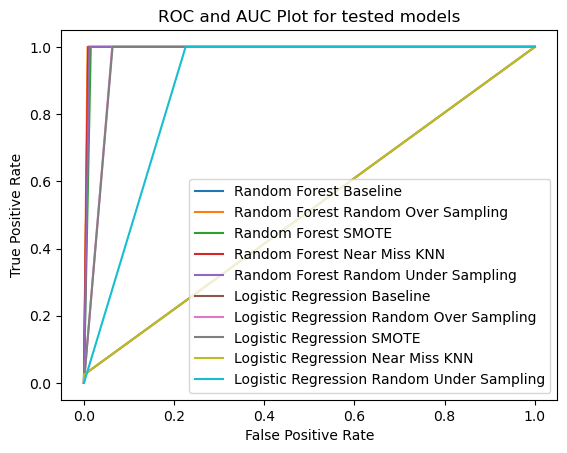

In [62]:
u = u.reload(u)
model_prediction, model_scores_table_T, model_coef_table = u.model_run(models,
                                                                       resamplers,
                                                                       X,
                                                                       y,
                                                                       random_state,
                                                                       test_size,
                                                                       verbose,
                                                                       print_report)

In [63]:
model_scores_table_T

,Model,Model Name,Resampler Name,TN,FP,FN,TP,Precision 0,Precision 1,Recall 0,Recall 1,F1-Score 0,F1-Score 1,Support 0,Support 1
0,"(DecisionTreeClassifier(max_depth=2, max_featu...",Random Forest,Baseline,26443,251,0,861,1.0,0.774281,0.990597,1.0,0.995276,0.872783,26694,861
1,"(DecisionTreeClassifier(max_depth=2, max_featu...",Random Forest,Random Over Sampling,26480,214,0,861,1.0,0.80093,0.991983,1.0,0.995975,0.889463,26694,861
2,"(DecisionTreeClassifier(max_depth=2, max_featu...",Random Forest,SMOTE,26291,403,0,861,1.0,0.681171,0.984903,1.0,0.992394,0.810353,26694,861
3,"(DecisionTreeClassifier(max_depth=2, max_featu...",Random Forest,Near Miss KNN,26443,251,0,861,1.0,0.774281,0.990597,1.0,0.995276,0.872783,26694,861
4,"(DecisionTreeClassifier(max_depth=2, max_featu...",Random Forest,Random Under Sampling,26370,324,0,861,1.0,0.726582,0.987862,1.0,0.993894,0.841642,26694,861
5,"LogisticRegression(C=0.1, class_weight='balanc...",Logistic Regression,Baseline,26693,1,840,21,0.969491,0.954545,0.999963,0.02439,0.984491,0.047565,26694,861
6,"LogisticRegression(C=0.1, class_weight='balanc...",Logistic Regression,Random Over Sampling,25021,1673,0,861,1.0,0.339779,0.937327,1.0,0.96765,0.507216,26694,861
7,"LogisticRegression(C=0.1, class_weight='balanc...",Logistic Regression,SMOTE,25001,1693,0,861,1.0,0.337118,0.936578,1.0,0.96725,0.504246,26694,861
8,"LogisticRegression(C=0.1, class_weight='balanc...",Logistic Regression,Near Miss KNN,26693,1,840,21,0.969491,0.954545,0.999963,0.02439,0.984491,0.047565,26694,861
9,"LogisticRegression(C=0.1, class_weight='balanc...",Logistic Regression,Random Under Sampling,20676,6018,0,861,1.0,0.125164,0.774556,1.0,0.872958,0.222481,26694,861


In [64]:
model_coef_table

,Features,Random Forest Baseline,Random Forest Random Over Sampling,Random Forest SMOTE,Random Forest Near Miss KNN,Random Forest Random Under Sampling,Logistic Regression Baseline,Logistic Regression Random Over Sampling,Logistic Regression SMOTE,Logistic Regression Near Miss KNN,Logistic Regression Random Under Sampling
0,DEEP_CHANNELS_202201,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,DEEP_CHANNELS_202202,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,DEEP_CHANNELS_202203,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,DEEP_CHANNELS_202204,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,DEEP_CHANNELS_202205,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
100,AMP_MA_VAR,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-0.027527,-0.000720,-0.004081,-0.027527,-0.041305
101,NUM_TRANSACTIONS_MA_1,0.003728,0.000000,0.000000e+00,0.003728,0.001907,0.003434,0.007215,0.009847,0.003434,0.012108
102,NUM_TRANSACTIONS_MA_2,0.017910,0.017609,2.884484e-13,0.017910,0.027197,0.011603,0.023781,0.027263,0.011603,0.025587
103,NUM_TRANSACTIONS_MA_3,0.026616,0.014397,9.180475e-03,0.026616,0.008100,-0.007033,-0.005022,-0.005265,-0.007033,-0.004217


# Section 5: Evaluate the Results

This section will split up into separate analyses for each business question.
Each section will be comprised of a brief analysis, and evaluation and conclusion.

### Question 2: Are mono-product-family users more likely to have channel innactivity in a six month window?

### Question 3: Can transactional data alone safely predict channel innactivity in a six month window?

# Question 1: What are aspects of a transactional dataset that can be used for understanding channel innactivity in a six month window?

The objetctive behind this question is to understand what predictors from our transactional database have the higest impact on model performance.

We will:

(1) Check de Model Scores to identify best models;

(2) We will verify which features had greater impact on our best models;

(3) We will then reavaluate our models using only the best predictor to check if performance boosts up.

##### Quick Primer com classifier evaluation scores

Quick Primer on reading the Confusion Matrix and Classification report measures
How to read the quadrants of the matrix:

True Negative | False Positive

False Negative | True Positive

Precision
Measure of how many of the positive predictions made are correct (true positives).
Formula: TP/(TP+FP)

Recall
Measure of how many of the positive cases the classifier correctly predicted considering the over all positive cases in the data.
It is sometimes also referred to as Sensitivity
Formula: TP/(TP+FN)

f1-Score
Harmonic mean of precision and recall

Accuracy
Measure of the number of correct predictions over all predictions
Formula: (TP+TN)/(TP+TN+FP+FN)

In [65]:
min_max_df = u.pd.DataFrame()
min_max_df['Max'] = model_scores_table_T.drop(columns=['Model','Model Name','Resampler Name']).max(axis = 0)
min_max_df['Min'] = model_scores_table_T.drop(columns=['Model','Model Name','Resampler Name']).min(axis = 0)
min_max_df

,Max,Min
TN,26693,20676
FP,6018,1
FN,840,0
TP,861,21
Precision 0,1.0,0.969491
Precision 1,0.954545,0.125164
Recall 0,0.999963,0.774556
Recall 1,1.0,0.02439
F1-Score 0,0.995975,0.872958
F1-Score 1,0.889463,0.047565


### Classfication Score analysis

All models had precision scores for the minority class (Precision 0) ranging from 0.07 to 0.15, recall from 0.01 to 0.84 and f1-score from 0.02 to 0.16. This is actually a rather distressing signal that, in overall, none of the models did a remarkable job at predicting innactivity. They were pretty simple bad at it.

One of most interesting difference between models are seeable through confusion matrices' True Negatives, False Positives, False Negatives and True Positives scores. 

The best case scenario shows that the some models actually did an interesting job of predicting True Negative. The best one predicted 357 cases (check Max True Negatives) of the 423 (check Support 0) innactivity targets in the test set. That score was achieved by Logistic Regression with Random Under Sampling model, which,not surpriselingy, had also the higest Recall.

This means the model is more confident at trying to predict the minority cases. There are a few models that had really low negative predictions as whole like the Random Forest Baseline and Near Miss KNN who score lowest practically didn’t even try to predict the minority cases (only 0,04% of predictions were for the minority class).

The downside of these models are the extremely high number of False Negatives they produce. For example: all the model that got high True Negatives also got a lot of False Neative, roughly 25% of the predictions the model did in the test setsfell in  to this cateory. 

The models with hight True Negative bring about another downside: their precision on predicting True Positive goes down a few points (from 99, 98% to 80% or so). This albeit beeing a bad news it isn't so important considering what we are trying to achieve here.

For the next step of the process we will elect the Models with higher Minority cases predictions. We see their Recall scores are high, but F1-Score and Precision are low. Further studies can look it fine tunning these models to try to reduce the False Negative scores, maybe using differnt class weights, penalization and solver methods.

To continue on this analysis I will choose the two models with high True Negatives but with their pairs lowest False Negative predictions. These are the Random Forest with Random Under Sampling and Logistic Regression with SMOTE. We will look their coeficients to get a feel.

In [ ]:
# Check the complete Model Coeficient Table
Model_Coef_Table['Coeficient Sum'] = 0
Model_Coef_Table['Coeficient Sum'] = Model_Coef_Table.drop(columns=['Features']).sum(axis = 1)
Model_Coef_Table.sort_values(by=['Coeficient Sum'],ascending=False)

In [ ]:
# What are the Top 10 coeficient for the Random ForestRandom Under Sampling?
top_coef_lr_ros = Model_Coef_Table.loc[:,['Features','CoefLogistic RegressionRandom Over Sampling']]
top_coef_lr_ros['Coef Module'] = abs(top_coef_lr_ros['CoefLogistic RegressionRandom Over Sampling'])
top_coef_lr_ros = top_coef_lr_ros.sort_values(by=['Coef Module'],ascending=False)[:10]


top_coef_lr_ros

In [ ]:
# What are the Top 10 coeficient for the Random ForestRandom Under Sampling?
top_coef_lr_smote = Model_Coef_Table.loc[:,['Features','CoefLogistic RegressionSMOTE']]
top_coef_lr_smote['Coef Module'] = abs(top_coef_lr_smote['CoefLogistic RegressionSMOTE'])
top_coef_lr_smote = top_coef_lr_smote.sort_values(by=['Coef Module'],ascending=False)[:10]


top_coef_lr_smote

In [ ]:
# What are the Top 10 coeficient for the Random ForestRandom Under Sampling?
top_coef_rf_rus = Model_Coef_Table.loc[:,['Features','CoefRandom ForestRandom Under Sampling']]
top_coef_rf_rus['Coef Module'] = abs(top_coef_rf_rus['CoefRandom ForestRandom Under Sampling'])
top_coef_rf_rus = top_coef_rf_rus.sort_values(by=['Coef Module'],ascending=False)[:10]


top_coef_rf_rus

### Coeficient Analysis

In this section we used Coeficiente Analysis for Logistic Regression. For the Random Forest feature importance analysis. We analyzed the module, or absolute number, of these coeficient so as to not exclude any negative valued coeficient with high impact.

Comparing both TOP 10 results of the models we can identity four features that were present in all TOP 10 counts of the analyzed models:
-DEEP_PIX_202205
-NUM_TRANSACTIONS_202205
-AMP_202205
-DEEP_PAYMENTS_202205


## Model tweaking based on feature importance

In [ ]:
#Declare independent variables (X) and dependent variable (y)

# Based on our prior analysis, I've decided to test the perfomance of the models with less predictors. 
# So will drop most of them and leave only the top 10.

# To avoid writing them out every time, we save the names of the estimators of our model in a list. 
independent_variables=[
                        'DEEP_PIX_202205',
                        'NUM_TRANSACTIONS_202205',
                        'AMP_202205',
                        'DEEP_PAYMENTS_202205'
                      ]

X1 = dataX = data.loc[:,'PIX_STDEV':'NUM_TRANSACTIONS_MA_VAR'] # Drop Id columns
y1 = data['FLG_202206']

In [ ]:
#Instantiate empty list to hold models for coeficient evaluation 
model_prediction = []

model_scores_table = u.pd.DataFrame()
model_scores_table['Scores'] = ['Model','Model Name','Resampler Name','TN','FP','FN','TP','Precision 0','Precision 1','Recall 0','Recall 1','F1-Score 0','F1-Score 1','Support 0','Support 1']

for model_name in models:
    for resampler_name in resamplers:
        model,cr,cm,precision,recall,fbeta_score,support = u.model_predict(model_name,resampler_name,X1,y1,random_state,test_size,verbose)
        models_scores_append = [model,model_name,resampler_name,cm[0][0],cm[0][1],cm[1][0],cm[1][1],precision[0],precision[1],recall[0],recall[1],fbeta_score[0],fbeta_score[1],support[0],support[1]]
        
        model_scores_table[model_name+' '+resampler_name] = models_scores_append
        model_prediction.append((model,model_name,resampler_name))

# Create Model Coeficient Table
Model_Coef_Table = u.Model_Coef_Table(model_prediction, X1)

In [ ]:
# Let's transpose the Model Scores Table to get a better look
model_scores_table_T = model_scores_table.T
# Now let's promote the first row as header and drop the index
model_scores_table_T = model_scores_table_T.rename(columns=model_scores_table_T.iloc[0]).drop(model_scores_table_T.index[0]).reset_index(drop=True)
# Let's clean out the score related to predicting the majority class (1) and focus only on the minority
model_scores_table_T = model_scores_table_T.drop(columns=['Precision 1','Recall 1','F1-Score 1'])
model_scores_table_T

min_max_df = u.pd.DataFrame()
min_max_df['Max'] = model_scores_table_T.drop(columns=['Model','Model Name','Resampler Name']).max(axis = 0)
min_max_df['Min'] = model_scores_table_T.drop(columns=['Model','Model Name','Resampler Name']).min(axis = 0)
min_max_df

# Evaluation

Though the exploratory analysis indicated the possibily of finding correlation between transaction patterns and innactivity, the two classifiers and 4 resampling techniques used did not present good performance on this highly imbalanced dataset. 

The models just didn't perform well! Unfortunatelly. But hey, this is a scientific approach, know that something doesn't work is also a valid result, it just brushes off the false positives from your line of sight.

All models had precision scores ranging from 0.08 to 0.09, recall from 0.83 to 0.85 and f1-score at exactlly 0.15. The main difference seeable at the confusion matrix, with slight differences on the true/false positive/negative predictions. The RandomForest with Random Under Sampling had similiar measures: precision at 0.09, recall at 0.77 and f1-score at 0.16.
Exemple of Classification Report and Confusion Matrix for the Logistic Regression with Baseline model.

The models actually did an interesting job of predicting 325+ cases of the 423 innactivity targets in the test set (you can see that looking at the confusion matrix's top left quadrant, 358 in the example above). That is why the Recall (or sensitivity) is high. 

This means the model is more confident at trying to predict the minority cases (the Random Forest Baseline practically didn't even try to predict the minority cases, in the report in only classified 15 as negatives, and 14 of them were flase - check the print screen bellow).

# Conclusion

Unfortunately this project doesn't seem to provide strong evidence towards answering either positively or negatively the business question provided.

Our exploratory analysis show their is a potential correlation to be explored between innactivaty, depth (specially PIX) and amplitude. But, the use of classifier models, at least with the present configuration, haven't presented promising results.

### Recommendations on future studies

1. Study the use of time series prediction techniques as a subsititue for Classifiers
2. Use the accumlative transactional variation on 5 months prior to the 6th month innactivity prediction may wielf better results than using the absolute number of transations per month as features.